# Imports

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers,losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# resnet50
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Data Loading

In [2]:
train_dir ='/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train'
test_dir = '/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Valid'

In [10]:
# Augment train set only
train_data_generator = ImageDataGenerator(
                    validation_split=0.15,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function=preprocess_input,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

val_data_generator = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    validation_split=0.15)

In [55]:
HYP = dict(
    seed = 77,
    batch_size = 32,
    img_size = (256,256),
    epochs = 20,
    patience = 5)

In [56]:
train_generator = train_data_generator.flow_from_directory(
                train_dir, target_size=HYP['img_size'],
                shuffle=True, seed=HYP['seed'],
                class_mode='categorical', 
                batch_size=HYP['batch_size'],
                subset="training")

validation_generator = val_data_generator.flow_from_directory(
                    train_dir, target_size=HYP['img_size'],
                    shuffle=False, seed=HYP['seed'],
                    class_mode='categorical',
                    batch_size=HYP['batch_size'],
                    subset="validation")

Found 12750 images belonging to 10 classes.

Found 2250 images belonging to 10 classes.


# LearningRateScheduler

In [57]:
# LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.001 * (5 - epoch))
    
lr_scheduler = LearningRateScheduler(scheduler)

# early_stopping    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)

callbacks = [early_stopping, lr_scheduler]

# Modeling

In [58]:
# Resnet50
model_res50 = Sequential()

model_res50.add(ResNet50(
include_top=False,
pooling='avg',
weights='imagenet'
))

model_res50.add(Dense(1024, activation='relu'))

model_res50.add(Dropout(0.5))

model_res50.add(Dense(10, activation='softmax'))

model_res50.layers[0].trainable = False

model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

model_res50.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_7"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2048)              23587712  

                                                                 

 dense_14 (Dense)            (None, 1024)              2098176   

                                                                 

 dropout_7 (Dropout)         (None, 1024)              0         

                                                                 

 dense_15 (Dense)            (None, 10)                10250     

                                                                 


Total params: 25,696,138

Trainable params: 2,108,426

Non-trainable params: 23,587,712

_________________________________________________________________


# Learning

In [59]:
fit_history = model_res50.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch_training,
            validation_steps=steps_per_epoch_validation,
            epochs=HYP['epochs'],
            validation_data=validation_generator,
            verbose=1,
            callbacks=callbacks
            )

Epoch 1/20

221/399 [===============>..............] - ETA: 1:16 - loss: 1.1227 - accuracy: 0.6599

c:\Users\taka-\anaconda3\envs\tensorflow-new\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images

  warnings.warn(


399/399 [==============================] - 187s 459ms/step - loss: 0.9746 - accuracy: 0.6990 - val_loss: 0.5909 - val_accuracy: 0.8218 - lr: 0.0010

Epoch 2/20

399/399 [==============================] - 167s 417ms/step - loss: 0.6785 - accuracy: 0.7837 - val_loss: 0.5631 - val_accuracy: 0.8191 - lr: 0.0010

Epoch 3/20

399/399 [==============================] - 171s 428ms/step - loss: 0.6121 - accuracy: 0.8062 - val_loss: 0.5479 - val_accuracy: 0.8298 - lr: 0.0010

Epoch 4/20

399/399 [==============================] - 167s 419ms/step - loss: 0.5692 - accuracy: 0.8177 - val_loss: 0.4925 - val_accuracy: 0.8542 - lr: 0.0010

Epoch 5/20

399/399 [==============================] - 166s 415ms/step - loss: 0.5465 - accuracy: 0.8259 - val_loss: 0.4922 - val_accuracy: 0.8444 - lr: 0.0010

Epoch 6/20

399/399 [==============================] - 164s 410ms/step - loss: 0.5173 - accuracy: 0.8364 - val_loss: 0.4601 - val_accuracy: 0.8578 - lr: 0.0010

Epoch 7/20

399/399 [=========================

# evaluation

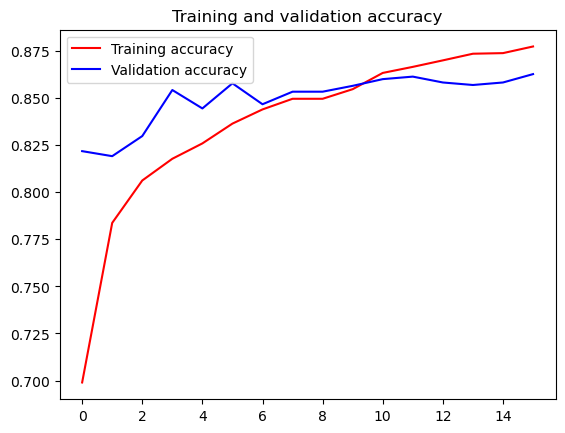

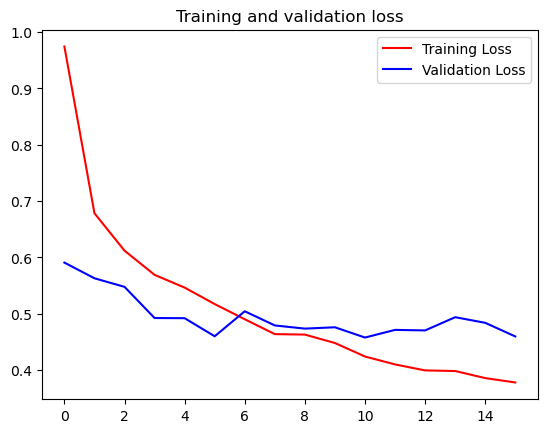

In [60]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

classes = train_generator.class_indices.keys()
classes

71/71 [==============================] - 17s 216ms/step


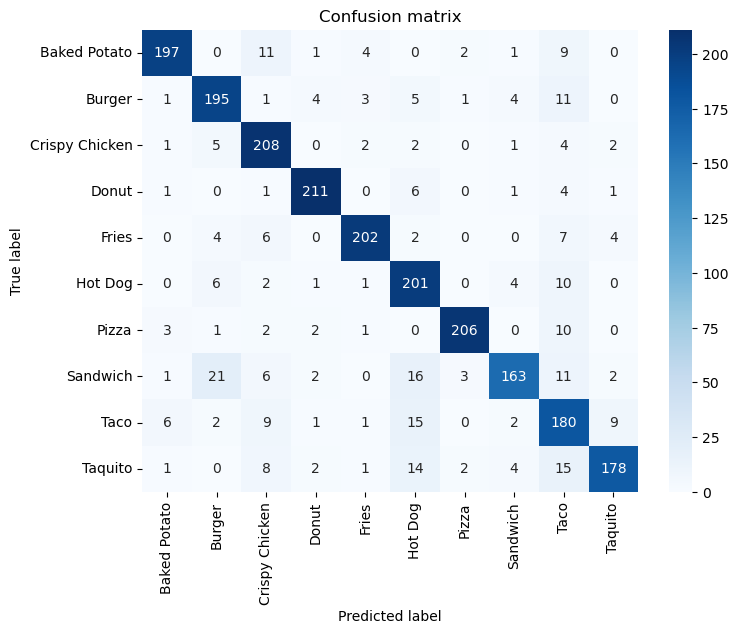

In [61]:
# Confusion matrix

classes = train_generator.class_indices.keys()

y_pred = np.argmax(model_res50.predict(validation_generator), axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [62]:
score = model_res50.evaluate(validation_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.45980820059776306

Test accuracy: 0.862666666507721


**Test accuracy: 0.8471111059188843→0.862666666507721<br>
2% improvement from last time！<br>
LearningRateScheduler is effective for improving accuracy.<br>
I will also try KerasTurner！<br>**